In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from env import get_db_url
import wrangle
from statistics import stdev
from sklearn.model_selection import train_test_split
from itertools import combinations, product, permutations
import sklearn.preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import TweedieRegressor
import scipy.stats as stats

### Acquire
- Looking at the dataset in SQL, many columns were missing data or had erroneous information.
- Zip code was not chose due to having county information via fips.
- Tax_Assessed was pulled to determine the tax rate but will not be used in modeling.

In [2]:
df = wrangle.get_zillow_data()

### Prepare
  
   - Data cleaning:
   - drop nulls
   - Converted fips(County_Code) to counties
   - convert floats to integers except for Number_of_Bedrooms
   
   
   - Determine what a "home" should be considered in terms of beds, baths, square feet.
       - The data has been updated to include only home with greater than 1 bed, 1 bath, and a minimum of 120 sq. ft.
   - Tax Appraised vs Tax Asseses (drop Tax Assesed)
  
   - Outliers:
   - Approximately 5% of data dropped to exclude extreme outliers.
   - Values are:
       - 7 Beds
       - 7.5 Baths
       - 10,000 or less sq. feet
       - 20,000 or less sq. feet (lot size)
       - $3.5M or less in appraised value
   


In [3]:
df = wrangle.prepare_zillow_data(df)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number_of_Bedrooms,2123966.0,3.308068,0.919100,1.00,3.00,3.000,4.00,2.500000e+01
Number_of_Bathrooms,2123966.0,2.241499,0.981043,1.00,2.00,2.000,3.00,3.200000e+01
Square_Feet,2123966.0,1861.543512,1158.960971,127.00,1260.00,1623.000,2206.00,9.525760e+05
Tax_Appraised_Value,2123966.0,459110.621375,666833.569081,23.00,189432.00,328132.000,533299.00,9.018846e+07
Year_Built,2123966.0,1960.869213,22.014132,1801.00,1949.00,1958.000,1975.00,2.016000e+03
Tax_Assessed,2123966.0,5594.591086,7686.866621,16.48,2544.19,4109.545,6395.74,1.078102e+06
Lot_Size,2123966.0,10666.656294,264924.354940,104.00,5638.00,6757.000,8527.00,3.710005e+08
Tax_Rate,2123966.0,1.322178,1.839770,0.00,1.17,1.240,1.36,1.859170e+03


**Takeaways:**
   - Number of bedrooms follows normal distribution, with the majority of bedrooms around 3.
   - Number of bathrooms is right-swkewed with the majority around 2.
   - Square feet is right-skewed with the majority of homes under 4000 sq feet.
   - Tax Appraised Value is right-skewed with the majority of homes under $1M.
   - Year built is normally distributed with the majority of homes being built right after 1950.
   - Lot size is normal-ish with right skewdness, majority of homes under 10000 sq feet.

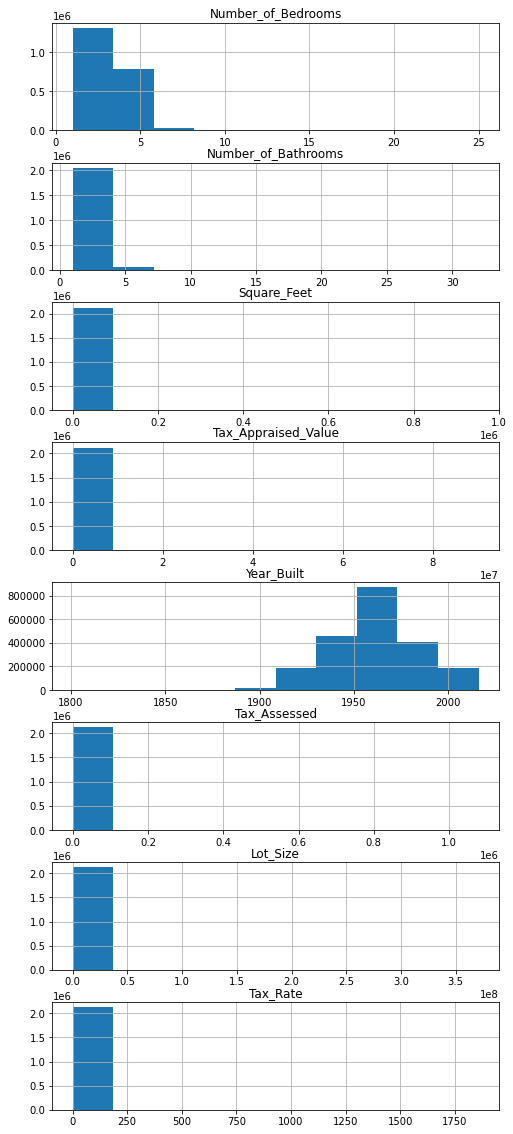

In [5]:
fig, axis = plt.subplots(8,1,figsize=(8, 20))
df.hist(ax=axis)
plt.show()

**Handling outliers**
The majority of customers are not going to be purchasing exorbitant homes.
   - Dataset adjusted to remove outliers.
   - Max bath = 7.5, max bed = 7, max appraised value = 3.5M, max sq. feet = 10,000, max lot size = 20,000

In [6]:
# removing signifcant outliers leaves ~94% of data.
df[(df.Tax_Appraised_Value>3_500_000) | (df.Number_of_Bathrooms >7.5) | (df.Number_of_Bedrooms >7) | (df.Square_Feet >10000) | (df.Lot_Size>20000)].shape[0]/ df.shape[0]

0.055193915533487826

In [7]:
df = wrangle.handle_outliers(df)

In [8]:
df.head()

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Feet,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,Lot_Size,Tax_Rate
4,4,2.0,3633,296425,2005,6941.39,Los Angeles,9826,2.34
7,3,2.0,2077,646760,1926,7924.68,Los Angeles,6490,1.23
18,3,1.0,1244,169471,1950,2532.88,Los Angeles,6021,1.49
19,3,2.0,1300,233266,1950,3110.99,Los Angeles,4917,1.33
20,3,2.0,1222,290492,1951,3870.25,Los Angeles,5500,1.33


### Explore

    - Questions to answer:
        - Does bed, bath, square feet relate to tax value? Add lot size, with time.
        - Does year built affect the tax value?
        - What does county, tax rate have to do with value?
        

In [9]:
train, validate, test = wrangle.split_zillow_data(df)
# split into train, validate, test before exploration

In [10]:
train.shape, validate.shape, test.shape

((1123771, 9), (481617, 9), (401348, 9))

**Takeaways:**
  - Heatmaps show strongest correlation between number of bathrooms, number of bedrooms, and square feet.
  - Tax Appraised Value is most strongly coorelated with square feet in overall, and in all 3 counties seperately.
  - Orange county has the strongest negative correlation between tax rate and tax appraised value(but still moderately weak)
  - 

<AxesSubplot:>

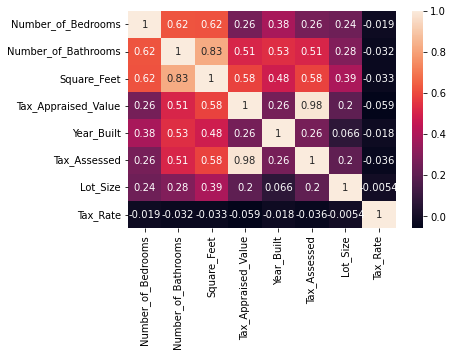

In [11]:
sns.heatmap(train.corr(),annot=True)
# in all three counties, highest correlation bewtween number of bedrooms to number of bathrooms and square feet, 
# square feet correlated to tax appraised value

Hypothesis test: 
Null: There is no relationship between tax appraised value and square feet
Alternative: There is a relationship between tax appraised value and square feet

In [101]:
alpha = .05
observed = pd.crosstab(train.Tax_Appraised_Value.sample(10000), train.Square_Feet.sample(10000))

In [102]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

0.24014313552618521

Hypothesis test: 
Null: There is no relationship between bedrooms and square feet
Alternative: There is a relationship between bedrooms and square feet

In [109]:
alpha = .05
observed = pd.crosstab(train.Number_of_Bedrooms.sample(10000), train.Square_Feet.sample(10000))

chi2, p, degf, expected = stats.chi2_contingency(observed)
p

0.300437799765579

In [ ]:
Hypothesis test: 
Null: There is no relationship between bathrooms and bedrooms
Alternative: There is a relationship between bathrooms and bedrooms

In [103]:
alpha = .05
observed = pd.crosstab(train.Number_of_Bathrooms.sample(10000), train.Number_of_Bedrooms.sample(10000))

In [104]:
chi2, p, degf, expected = stats.chi2_contingency(observed)
p

7.719315384385554e-08

In [13]:
train.County.value_counts(normalize=True)
# 66% of homes are in LA county

Los Angeles    0.661716
Orange         0.265006
Ventura        0.073278
Name: County, dtype: float64

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Homes on Zillow by County')

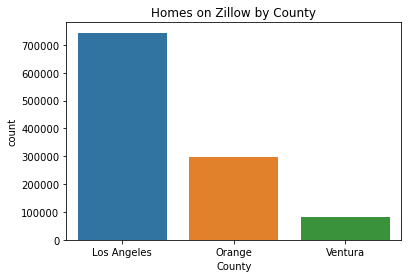

In [14]:
sns.countplot(train.County)
plt.title('Homes on Zillow by County')

<AxesSubplot:>

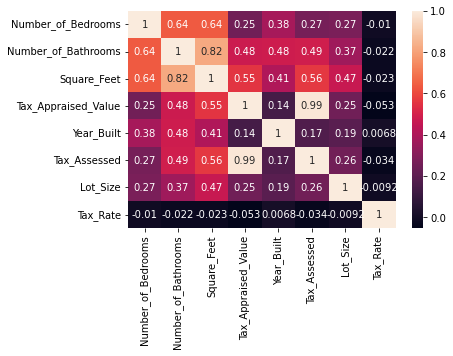

In [15]:
sns.heatmap(LA.corr(),annot=True)
#  LA county's highest correlation to tax appraisal is square feet (outside of tax ammount)

<AxesSubplot:>

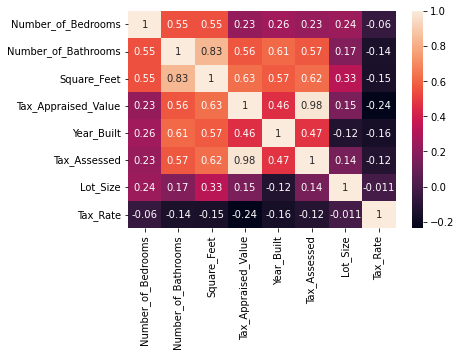

In [16]:
sns.heatmap(Orange.corr(),annot=True)
# Orange county's highest coorelation to tax appraisal is square feet (outside of tax ammount)

<AxesSubplot:>

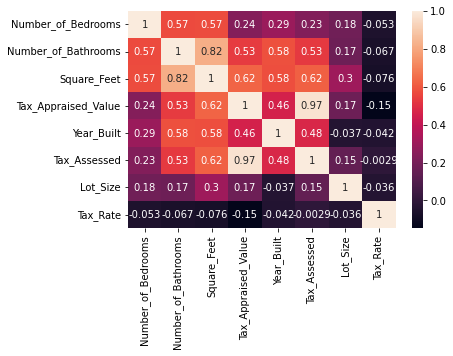

In [17]:
sns.heatmap(Ventura.corr(),annot=True)
# Ventura county's highest coorelation to tax appraisal is square feet (outside of tax ammount)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


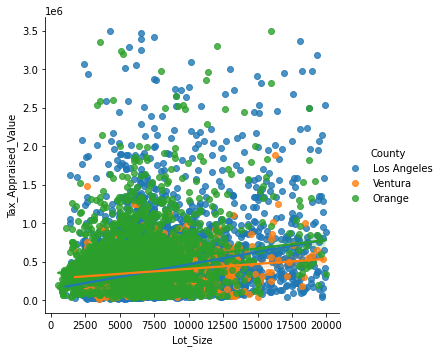

In [81]:
sns.lmplot('Lot_Size', 'Tax_Appraised_Value', data=train.sample(10000), scatter=True, hue='County', col=None)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


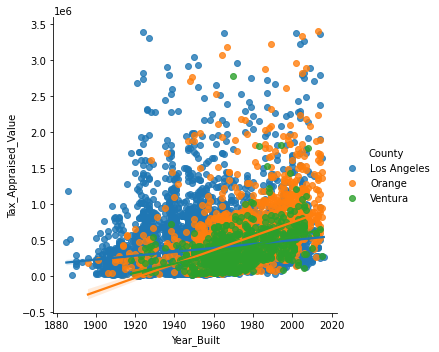

In [76]:
sns.lmplot('Year_Built','Tax_Appraised_Value', data=train.sample(10000), scatter=True, hue='County', col=None)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


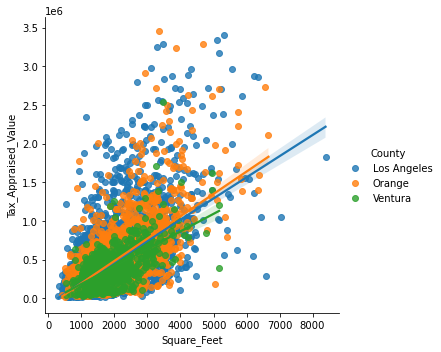

In [77]:
sns.lmplot('Square_Feet', 'Tax_Appraised_Value',data=train.sample(10000), scatter=True, hue='County', col=None)

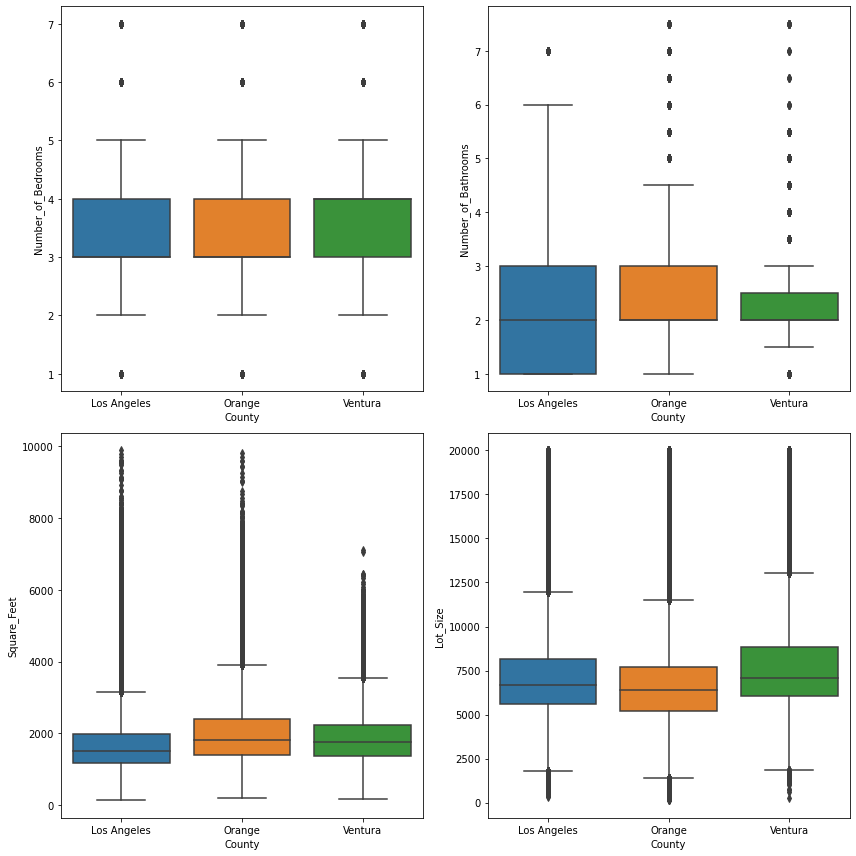

In [21]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Number_of_Bedrooms)
plt.subplot(2,2,2)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Number_of_Bathrooms)
plt.subplot(2,2,3)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Square_Feet)
plt.subplot(2,2,4)
sns.boxplot(data=train.sample(10000),x=train.County,y=train.Lot_Size)
plt.tight_layout()
plt.show()

Perform Chi-Squared test on relationships between bed, bath, sq. ft, lot size and Tax Appraised Value
Null: There is no relationship between square feet and tax appraised value
Alternative: There is a relationship between square feet and tax appraised value

aplha = .05

**Notes:** 
- Orange County has a higher median tax appraised value with a higher distribution of homes valued over 1M. 
- Ventura county has more outliers than both the other counties around 3.5M but otherwise is more compactly distributed at less than 1M.

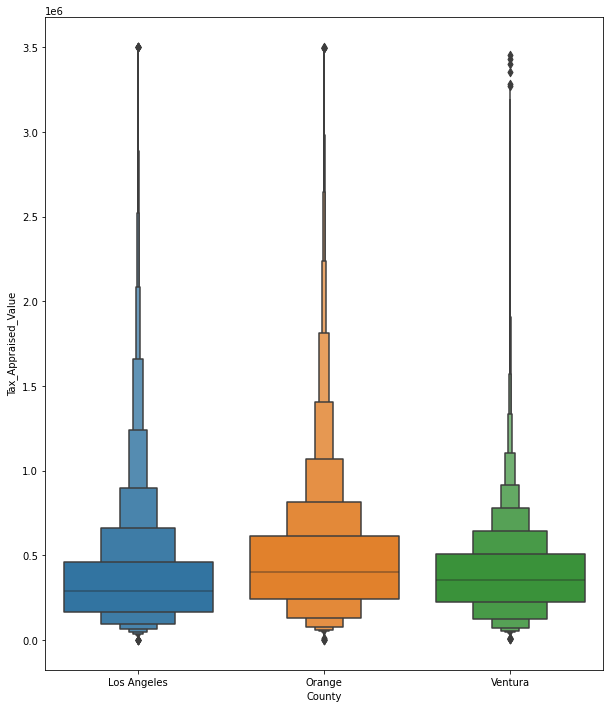

In [22]:
plt.figure(figsize=(10,12))
sns.boxenplot(data=train, y=train.Tax_Appraised_Value, x=train.County)
plt.show()

**ANOVA TEST:**
- Null Hypothesis: Tax Appraised Value is equal across all counties.
- Alternative Hypothesis: Tax Appraised Value is not equal across all counties.

In [89]:
alpha = .05

In [98]:
stats.f_oneway(LA['Tax_Appraised_Value'], Orange['Tax_Appraised_Value'], Ventura['Tax_Appraised_Value'])

F_onewayResult(statistic=16392.057974321582, pvalue=0.0)

### Scaling
 - will model with scaled and unscaled data
 - scaled to normalize and reduce the weight the of remaining outliers

In [23]:
columns_to_scale = ['Number_of_Bedrooms','Number_of_Bathrooms', 'Square_Feet', 'Lot_Size', 'Year_Built']

#### Quantile Scaling

In [24]:
scaler = sklearn.preprocessing.QuantileTransformer(output_distribution='normal')
train_scaled = train.copy()
train_scaled[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])

<Figure size 720x432 with 0 Axes>

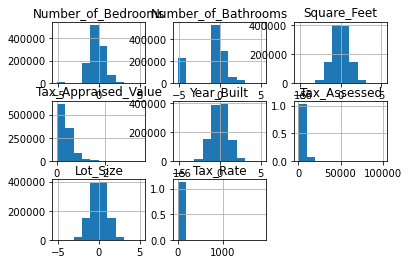

In [25]:
plt.figure(figsize=(10, 6))
train_scaled.hist()
plt.show()

#### Min Max Scaling

In [112]:
scaler = sklearn.preprocessing.MinMaxScaler()
train_scaled_MM = train.copy()
train_scaled_MM[columns_to_scale] = scaler.fit_transform(train_scaled[columns_to_scale])

In [113]:
scaler = sklearn.preprocessing.StandardScaler()
train_scaled_SS = train.copy()
train_scaled_SS[columns_to_s] = scaler.fit_transform(train_scaled_SS[train])


ValueError: Boolean array expected for the condition, not int64

### Modeling 

**Establish a baseline**

In [26]:
X_train = train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_test = test['Tax_Appraised_Value']

In [27]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [28]:
y_train['TAV_pred_mean'] = round(train.Tax_Appraised_Value.mean(),2)
y_validate['TAV_pred_mean'] = round(train.Tax_Appraised_Value.mean(),2)

In [29]:
y_train['TAV_pred_median'] = round(train.Tax_Appraised_Value.median(),2)
y_validate['TAV_pred_median'] = round(train.Tax_Appraised_Value.median(),2)

In [30]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  363303.05 
Validate/Out-of-Sample:  362590.76


In [31]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.Tax_Appraised_Value, y_validate.TAV_pred_median)**(1/2)
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  373647.42 
Validate/Out-of-Sample:  372855.68


**Takeaways:** Out-of-sample data performs better than in-sample; model is not overfit. Using the mean is slightly better. 

#### Ordinary Least Squares Modeling

 - using bath, bed, square feet

In [120]:
X_train.head()

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Feet,County_Los Angeles,County_Orange,County_Ventura
1770122,2,1.0,1196,1,0,0
447946,3,1.0,1089,1,0,0
1866176,3,1.0,1134,1,0,0
1775434,3,2.5,1955,0,1,0
1567012,4,2.0,2174,1,0,0


In [114]:
X_train = train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_test = test['Tax_Appraised_Value']

In [115]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [116]:
# create the model
lm = LinearRegression(normalize=True)

In [117]:
# fit the model
lm.fit(X_train, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [118]:
# train the model
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [119]:
# evaluate RMSE
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

RMSE in Sample:  288681.0


- Using bath, bed, square feet, year built, and lot size

In [38]:
X_train = train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_test = test['Tax_Appraised_Value']

In [39]:
train.head(1)

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Feet,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,Lot_Size,Tax_Rate
1770122,2,1.0,1196,466607,1927,5583.71,Los Angeles,10794,1.2


In [40]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [41]:
# create the model
lm = LinearRegression(normalize=True)

In [42]:
# fit the model
lm.fit(X_train, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [43]:
# train the model
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [44]:
# evaluate RMSE
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

RMSE in Sample:  288508.37


**Using quantile scaled data**

In [45]:
X_train = train_scaled.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_test = test['Tax_Appraised_Value']

In [46]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [47]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [48]:
y_train['TAV_pred_lm_scaled'] = lm.predict(X_train)

In [49]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

RMSE in Sample:  309633.03


**Using Min Max scaled data**

In [83]:
X_train = train_scaled_MM.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate', 'Year_Built'])
y_test = test['Tax_Appraised_Value']

In [84]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [85]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [86]:
y_train['TAV_pred_lm_scaled_MM'] = lm.predict(X_train)

In [87]:
rmse_train_MM = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled_MM)**(1/2)
print('RMSE in Sample: ', round(rmse_train_MM,2))

RMSE in Sample:  309166.58


### Tweedie Regressor Modeling

In [50]:
X_train = train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_test = test['Tax_Appraised_Value']

In [51]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [52]:
# create the model
glm = TweedieRegressor(power=0, alpha=1)

In [53]:
# fit the model
glm.fit(X_train, y_train.Tax_Appraised_Value)

TweedieRegressor(alpha=1, power=0)

In [54]:
y_train['TAV_pred_glm'] = glm.predict(X_train)

In [55]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_glm)**(1/2)
print('Tweedie-RMSE in Sample: ', round(rmse_train,2))

Tweedie-RMSE in Sample:  292051.04


#### Using scaled data

In [56]:
X_train = train_scaled.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_train = train['Tax_Appraised_Value']

X_validate = validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_validate = validate['Tax_Appraised_Value']

X_test = test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Lot_Size', 'Tax_Rate'])
y_test = test['Tax_Appraised_Value']

In [57]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [58]:
# create the model
glm = TweedieRegressor(power=0, alpha=1)

In [59]:
glm.fit(X_train, y_train.Tax_Appraised_Value)

TweedieRegressor(alpha=1, power=0)

In [60]:
y_train['TAV_pred_glm_scaled'] = glm.predict(X_train)

In [61]:
rmse_train_scaled = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_glm_scaled)**(1/2)
print('Tweedie-RMSE in Sample: ', round(rmse_train_scaled,2))

Tweedie-RMSE in Sample:  325659.79


In [62]:
df.head()

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Feet,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,Lot_Size,Tax_Rate
4,4,2.0,3633,296425,2005,6941.39,Los Angeles,9826,2.34
7,3,2.0,2077,646760,1926,7924.68,Los Angeles,6490,1.23
18,3,1.0,1244,169471,1950,2532.88,Los Angeles,6021,1.49
19,3,2.0,1300,233266,1950,3110.99,Los Angeles,4917,1.33
20,3,2.0,1222,290492,1951,3870.25,Los Angeles,5500,1.33


In [63]:
dummy_df = pd.get_dummies(df[['County']],dummy_na=False, drop_first=False)
df = pd.concat([df, dummy_df], axis=1)

In [64]:
df.head(1)

,Number_of_Bedrooms,Number_of_Bathrooms,Square_Feet,Tax_Appraised_Value,Year_Built,Tax_Assessed,County,Lot_Size,Tax_Rate,County_Los Angeles,County_Orange,County_Ventura
4,4,2.0,3633,296425,2005,6941.39,Los Angeles,9826,2.34,1,0,0


In [65]:
train,validate,test = wrangle.split_zillow_data(df)

train on each county

In [66]:
LA = df[df.County == 'Los Angeles']
Orange = df[df.County == 'Orange']
Ventura = df[df.County == 'Ventura']

In [67]:
LA_train, LA_validate, LA_test = wrangle.split_zillow_data(LA)

In [68]:
LA_train.shape, LA_validate.shape

((743043, 12), (318448, 12))

In [69]:
X_train = LA_train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_train = LA_train['Tax_Appraised_Value']

X_validate = LA_validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_validate = LA_validate['Tax_Appraised_Value']

X_test = LA_test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_test = LA_test['Tax_Appraised_Value']

In [70]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [71]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

LinearRegression(normalize=True)

In [72]:
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [73]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

AttributeError: 'DataFrame' object has no attribute 'TAV_pred_lm_scaled'

In [ ]:
Orange_train, Orange_validate, Orange_test = wrangle.split_zillow_data(Orange)

In [ ]:
X_train = Orange_train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_train = Orange_train['Tax_Appraised_Value']

X_validate = Orange_validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_validate = Orange_validate['Tax_Appraised_Value']

X_test = Orange_test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_test = Orange_test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))

In [ ]:
Ventura_train, Ventura_validate, Ventura_test = wrangle.split_zillow_data(Ventura)

In [ ]:
X_train = Ventura_train.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_train = Ventura_train['Tax_Appraised_Value']

X_validate = Ventura_validate.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_validate = Ventura_validate['Tax_Appraised_Value']

X_test = Ventura_test.drop(columns =['Tax_Appraised_Value','Tax_Assessed', 'County', 'Tax_Rate'])
y_test = Ventura_test['Tax_Appraised_Value']

In [ ]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [ ]:
lm.fit(X_train, y_train.Tax_Appraised_Value)

In [ ]:
y_train['TAV_pred_lm'] = lm.predict(X_train)

In [ ]:
rmse_train = mean_squared_error(y_train.Tax_Appraised_Value, y_train.TAV_pred_lm_scaled)**(1/2)
print('RMSE in Sample: ', round(rmse_train,2))